In [1]:

import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [2]:
from keras.datasets import fashion_mnist

(X_train,y_train),(X_test,y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
WIDTH, HEIGHT = 28, 28
num_classes = 10
img_channel = 1
img_shape = (WIDTH, HEIGHT, img_channel)
noise_dim = 100

In [4]:
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [5]:
X_train, X_test = prep_pixels(X_train, X_test)

In [6]:
X_train[1].shape

(28, 28)

In [7]:
def show_example(index):
  print(decode_sequence([train_captions[index]]))
  img=train_images[index]
  img = img.reshape(64, 64)
  plt.imshow(img)

In [8]:
show_example(654)

NameError: ignored

In [9]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [10]:
def build_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(7*7*256, use_bias=False,input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (1, 1), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    z = layers.Input(shape= (noise_dim,))
    label = layers.Input(shape=(1,), dtype = 'int32')
    
    label_embedding = layers.Embedding(num_classes, noise_dim, input_length = 1)(label)
    label_embedding = layers.Flatten()(label_embedding)
    joined = layers.multiply([z, label_embedding])
    
    img = model(joined)
    return Model([z, label], img)

In [11]:
generator = build_generator_model()

In [12]:

def build_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                      input_shape=[28, 28, 2]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

  
    img = layers.Input(shape= (img_shape))
    label = layers.Input(shape= (1,), dtype = 'int32')
    
    label_embedding = layers.Embedding(input_dim = num_classes, output_dim = np.prod(img_shape), input_length = 1)(label)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape(img_shape)(label_embedding)
    
    concat = layers.Concatenate(axis = -1)([img, label_embedding])
    prediction = model(concat)
    return Model([img, label], prediction)

In [13]:

discriminator = build_discriminator_model()

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
learning_rate = 1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)

In [18]:
def gradient_penalty(batch_size, real_images, fake_images,labels):
    # Get the interpolated image
    alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        z = np.random.randint(0,1,size = (batch_size, noise_dim))
        # 1. Get the discriminator output for this interpolated image.
        pred = discriminator([interpolated,labels], training=True)

    # 2. Calculate the gradients w.r.t to this interpolated image.
    grads = gp_tape.gradient(pred, [interpolated])[0]
    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

In [19]:
Lambda = 10
@tf.function
def train_step(batch_size):
  
  idx = np.random.randint(0, X_train.shape[0], batch_size)
  Xtrain, labels = X_train[idx], y_train[idx]

  with tf.device('/device:GPU:0'): 
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      z = np.random.normal(0,1,size = (batch_size, noise_dim))

      generated_images = generator([z,labels], training=True)
      real_output = discriminator([Xtrain, labels], training=True)
      fake_output = discriminator([generated_images, labels], training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      # gp = gradient_penalty(batch_size, X_train, generated_images, y_train)
      disc_loss = disc_loss # + gp * 10

    tf.print(gen_loss,disc_loss)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
from IPython.display import Image, display
import time
epoch = 50000
def train(epochs):
  for epoch in range(epochs):
    start = time.time()
    batch_size = 1000

    train_step(batch_size)
      

    print ('Time for epoch {} is {}(s)'.format(epoch + 1, time.time()-start))
    
    # if (epoch + 1) % 5 == 0:
    #     idx = np.random.randint(0, 1000, 1)
    #     labels =  y_train[idx]

    #     z = np.random.normal(0,1,size = (1, noise_dim))

    #     img = np.array(generator([z,labels]))
    #     print(labels)
    #     img = img * 255
    #     img = img.reshape(32,32,3)
    #     plt.imshow(img)
    
    #     display(plt.plot(img))
    #     plt.show()
    #     display.display(plt.gcf())
    #     display.clear_output(wait=True)


In [21]:
train(50000)

0.693826914 1.4006393
Time for epoch 1 is 8.97117567062378(s)
0.692651749 1.36949754
Time for epoch 2 is 0.1190953254699707(s)
0.692326546 1.3381747
Time for epoch 3 is 0.11797070503234863(s)
0.691375554 1.30890393
Time for epoch 4 is 0.11773347854614258(s)
0.688709915 1.28472447
Time for epoch 5 is 0.11761903762817383(s)
0.685135782 1.2612021
Time for epoch 6 is 0.1317002773284912(s)
0.67799449 1.24080682
Time for epoch 7 is 0.11884427070617676(s)
0.670520902 1.22442544
Time for epoch 8 is 0.12263703346252441(s)
0.662395775 1.20555496
Time for epoch 9 is 0.11854338645935059(s)
0.65384078 1.19234419
Time for epoch 10 is 0.11673855781555176(s)
0.641458869 1.18349361
Time for epoch 11 is 0.1156778335571289(s)
0.63122642 1.17285633
Time for epoch 12 is 0.117034912109375(s)
0.619229615 1.16603482
Time for epoch 13 is 0.11612749099731445(s)
0.608259618 1.15950155
Time for epoch 14 is 0.12204790115356445(s)
0.599538565 1.15367126
Time for epoch 15 is 0.12185072898864746(s)
0.589933217 1.1474

KeyboardInterrupt: ignored

(1, 1)
[[3]]


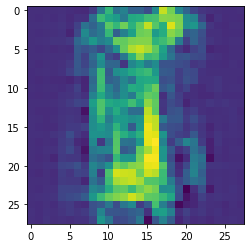

In [122]:
idx = np.random.randint(0, 1000, 1)
# labels =  y_train[idx]

name2idx = {'T-shirt/top' : 0,
            'Trouser' : 1,
            'Pullover' : 2,
            'Dress' : 3,
            'Coat' : 4,
            'Sandal' : 5,
            'Shirt' : 6, 
            'Sneaker' : 7,
            'Bag' : 8, 
            'Ankle boot' : 9}



labels = [name2idx['Dress']]

labels = np.expand_dims(labels, axis=1)

print(labels.shape)

z = np.random.normal(0,1,size = (1, noise_dim))

img = np.array(generator([z,labels]))
print(labels)

img = img.reshape(28,28)
plt.imshow(img)

In [114]:
img = np.array(generator(np.expand_dims(np.array(train_captions[5432]), axis=0)))
print(decode_sequence([train_captions[5432]]))
img = img.reshape(64,64)
plt.imshow(img)

NameError: ignored

In [ ]:
plt.imshow(train_images[432].reshape(64,64))
print(decode_sequence([train_captions[432]]))

In [ ]:
noise = tf.random.normal([1, 100])
img = np.array(generator(noise))
# print(decode_sequence([train_captions[index]]))
img = img.reshape(28,28)
plt.imshow(img)

In [73]:
name2idx = {'T-shirt/top' : 0,
            'Trouser' : 1,
            'Pullover' : 2,
            'Dress' : 3,
            'Coat' : 4,
            'Sandal' : 5,
            'Shirt' : 6, 
            'Sneaker' : 7,
            'Bag' : 8, 
            'Ankle boot' : 9}

labelss = name2idx['Trouser']

labelss = [labelss]

z = np.random.normal(0,1, size = (1, noise_dim))

img = np.array(generator([z,labelss]))

print(labels)

img = img.reshape(28,28)
plt.imshow(img)

8


ValueError: ignored

In [69]:
name2idx = {'T-shirt/top' : 0,
            'Trouser' : 1,
            'Pullover' : 2,
            'Dress' : 3,
            'Coat' : 4,
            'Sandal' : 5,
            'Shirt' : 6, 
            'Sneaker' : 7,
            'Bag' : 8, 
            'Ankle boot' : 9}

labels =name2idx['Bag']
labels

8

In [151]:
generator.save_weights(f'generator-epochs-50000-learning_rate-{learning_rate}.h5')
discriminator.save_weights(f'discriminator-epochs-50000-learning_rate-{learning_rate}.h5')

In [24]:
def generate_sample(label):
  name2idx = {'T-shirt/top' : 0,
              'Trouser' : 1,
              'Pullover' : 2,
              'Dress' : 3,
              'Coat' : 4,
              'Sandal' : 5,
              'Shirt' : 6, 
              'Sneaker' : 7,
              'Bag' : 8, 
              'Ankle boot' : 9}



  labels = [name2idx[label]]

  labels = np.expand_dims(labels, axis=1)

  z = np.random.normal(0,1,size = (1, noise_dim))

  img = np.array(generator([z,labels]))

  img = img.reshape(28,28)
  plt.imshow(img)

In [25]:
generator.load_weights('generator-epochs-50000-learning_rate-0.0001.h5')

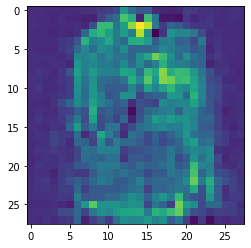

In [112]:
generate_sample('Shirt')